# Modeling with TensorFlow


In [ ]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    tf.test.gpu_device_name()
    # need to use gpu runtime accelerator!
    !pip install imageai
    from google.colab import drive
    drive.mount('/content/gdrive')

In [28]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
import cv2 as cv
from imageai.Detection import ObjectDetection
import os
import random, math

# Create generator


In [15]:
!pwd

/c/Users/User/Documents/GitHub/sidewalks_deep-learning


In [2]:
if IN_COLAB:
    tf.test.gpu_device_name()     # need to use gpu runtime accelerator!
    os.chdir(f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(f'./images/')
!pwd

In [29]:
#move images into train, test, validate folders with subfolders for classes
test_ratio = .15
SPLIT_DATA = True # switch if need to divide out data
if SPLIT_DATA:
    for label in ['sidewalk', 'no_sidewalk']:
        %cd ./$label
        listing = os.popen('ls').read().strip().split(sep='\n')
        random.shuffle(listing) #inplace
        im_count = len(listing)
        test_size=val_size = math.ceil(test_ratio*im_count)
        train_size = im_count - (test_size + val_size)
        subfolders = ['train', 'test', 'vdate']
        for subfolder in subfolders:
            os.makedirs(os.path.join(os.path.dirname(os.getcwd()), subfolder, label))
        for item in range(0, train_size):
            moved = listing.pop()
            !mv $moved ../train/$label/$moved
        for item in range(0, test_size):
            moved = listing.pop()
            !mv $moved ../test/$label/$moved
        for item in range(0, val_size):
            moved = listing.pop()
            !mv $moved ../vdate/$label/$moved
        %cd ..
        !rmdir ./$label

[WinError 2] The system cannot find the file specified: './sidewalk'
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images\sidewalk
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images\no_sidewalk


Parameter format not correct - "sidewalk".


C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images


Invalid switch - "no_sidewalk".


### Parameters for data loading and modeling

In [5]:
idg_params={'rescale': 1./255}
augmentation_params = {'rotation_range': 15,
                        'zoom_range': 0.15,
                         'width_shift_range': 0.2,
                         'height_shift_range': 0.2,
                         'shear_range': 0.15,
                         'fill_mode': 'nearest',
                         'horizontal_flip': True}
datagen_params = {'batch_size': 8,
                  'target_size': (256,256),
                  'color_mode': 'rgb', 
                  'class_mode': 'binary'}
batch_size = 128
n_epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 200

In [6]:
train_datagen = ImageDataGenerator(**idg_params)
train_augmented_datagen = ImageDataGenerator(
    **idg_params,
    **augmentation_params)
test_datagen = ImageDataGenerator(**idg_params)
vdate_datagen = ImageDataGenerator(**idg_params)

In [7]:
# Flow training images in batches of 128 using train_datagen generator

train_generator = train_datagen.flow_from_directory(
        r'./train/',  # This is the source directory for training images
        **datagen_params)
test_generator = test_datagen.flow_from_directory(
        r'./test/',
        **datagen_params)
vdate_generator = vdate_datagen.flow_from_directory(
        r'./vdate/',
        **datagen_params)

Found 2087 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Found 448 images belonging to 2 classes.


In [23]:
#generator based caluculations
input_shape = train_generator.next()[0].shape[1:]
total_train_samples = train_generator.n
total_vdate_samples = vdate_generator.n
input_shape

(256, 256, 3)

### Convolutional Model

In [46]:
conv_model = tf.keras.models.Sequential()
conv_model.add(Conv2D(64, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
conv_model.add(Conv2D(32, (4, 4), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.20))
conv_model.add(Conv2D(32, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.20))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dropout(0.2))
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dropout(0.2))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 253, 253, 64)      3136      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 251, 251, 32)      18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 61, 61, 32)       

In [47]:
conv_history = conv_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        #validation_data=vdate_datagen,
        #validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=False)

Epoch 1/15
16/16 [==============================] - 39s 2s/step - loss: 0.6764 - accuracy: 0.6562
Epoch 2/15
16/16 [==============================] - 42s 3s/step - loss: 0.6340 - accuracy: 0.6953
Epoch 3/15
16/16 [==============================] - 45s 3s/step - loss: 0.6223 - accuracy: 0.7266
Epoch 4/15
16/16 [==============================] - 40s 3s/step - loss: 0.5932 - accuracy: 0.7422
Epoch 5/15
16/16 [==============================] - 41s 3s/step - loss: 0.6425 - accuracy: 0.6797
Epoch 6/15
16/16 [==============================] - 41s 3s/step - loss: 0.6657 - accuracy: 0.6250
Epoch 7/15
16/16 [==============================] - 54s 3s/step - loss: 0.6233 - accuracy: 0.6875
Epoch 8/15
16/16 [==============================] - 58s 4s/step - loss: 0.6650 - accuracy: 0.6562
Epoch 9/15
16/16 [==============================] - 52s 3s/step - loss: 0.6622 - accuracy: 0.6328
Epoch 10/15
16/16 [==============================] - 55s 3s/step - loss: 0.6016 - accuracy: 0.7266
Epoch 11/15
16/16 [

In [50]:
conv_history_with_val = conv_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_datagen,
        validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=False)

Epoch 1/15
15/16 [===========================>..] - ETA: 3s - loss: 0.5866 - accuracy: 0.7417

AttributeError: 'ImageDataGenerator' object has no attribute 'shape'

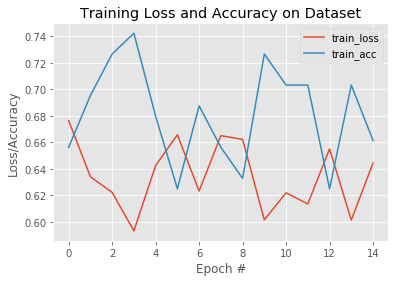

In [51]:
# plot the training loss and accuracy
n_epochs_range = np.arange(0, n_epochs)
plt.style.use("ggplot")
fig, ax = plt.subplots()
ax.plot(n_epochs_range, conv_history.history["loss"], label="train_loss")
#ax.plot(n_epochs_range, conv_history.history["val_loss"], label="val_loss")
ax.plot(n_epochs_range, conv_history.history["accuracy"], label="train_acc")
#ax.plot(n_epochs_range, conv_history.history["val_acc"], label="val_acc")

ax.set_title("Training Loss and Accuracy on Dataset")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.plot();

# Object Detection via Transfer Learning
This will use a pretrained model as the basis for a nn that identifies the part of an image file that contains the sidewalk object.

In [42]:
learning_rate = 0.0001
loss = 'binary_crossentropy'

In [43]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet')
pretrained_mobilenet.trainable = False

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [49]:
global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

mnet_model = tf.keras.Sequential([
  pretrained_mobilenet,
  global_pooling_layer,
  prediction_layer])

mnet_model.compile(optimizer=RMSprop(lr=learning_rate),
              loss=loss,
              metrics=['accuracy'])
mnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mnet_history = mnet_model.fit_generator(
        train_augmented_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_datagen
        validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=True)

# Object Segmentation

In [ ]:
model_path = "./models/yolo-tiny.h5"
input_path = "./input/test45.jpg"
output_path = "./output/newimage.jpg"

### tinyYOLOv3

In [ ]:
detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()

#returns dictionary with name and probabilities of objects detected
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

### ResNet